In [406]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
from datetime import datetime as dt
import os
from bs4 import BeautifulSoup
import urllib
import urllib.request as ur
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import ngrams
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
import nltk
from urllib.request import Request, urlopen
import random
import json


from PyPDF2 import PdfMerger

from google_play_scraper import Sort, reviews
from google_play_scraper import Sort, reviews_all
from matplotlib.backends.backend_pdf import PdfPages

from azure.ai.textanalytics import TextAnalyticsClient
from azure.core.credentials import AzureKeyCredential

In [413]:
def trends_analyze_new(filename, Rate, Date, Company):
    
    # read
    df = pd.read_csv (filename, lineterminator='\n')
    df['Review'] = df['Review'].astype(str)
    
    if Company == 'All':
        df = df
    else:
        df = df.loc[df['Company'] == Company]

    # joins all the sentenses
    df['Review'] = [df['Review'].iloc[i].replace("\r", " ") for i in range(len(df['Review']))]
    df['Date'] =  pd.to_datetime(df['Date'], format='%Y-%m-%d %H:%M:%S.%f')
    df = df.set_index(['Date'])
    df = df.drop('Unnamed: 0', axis = 1)
    df = df.loc[df['Rate'] == Rate].loc[Date]
    
    sentence = " ".join(df['Review'])
    # creates tokens, creates lower class, removes numbers and lemmatizes the words
    new_tokens = word_tokenize(sentence)
    new_tokens = [t.lower() for t in new_tokens]
    new_tokens =[t for t in new_tokens if t not in stopwords.words('english')]
    new_tokens = [t for t in new_tokens if t.isalpha()]

    # #counts the words, pairs and trigrams
    counted = Counter(new_tokens)
    counted_2= Counter(ngrams(new_tokens,2))
    counted_3= Counter(ngrams(new_tokens,3))

    # #creates 3 data frames and returns thems
    word_freq = pd.DataFrame(counted.items(),columns=['word','frequency']).sort_values(by='frequency',ascending=False)
    word_pairs =pd.DataFrame(counted_2.items(),columns=['pairs','frequency']).sort_values(by='frequency',ascending=False)
    trigrams =pd.DataFrame(counted_3.items(),columns=['trigrams','frequency']).sort_values(by='frequency',ascending=False)

    return word_freq, word_pairs, trigrams
    

In [414]:
def plot_chart_new(word_freq, word_pairs, trigrams):
    # create subplot of the different data frames
    fig, axes = plt.subplots(3,1,figsize=(9,15))
    sns.barplot(ax=axes[0],x='frequency',y='word',data=word_freq.head(30))
    sns.barplot(ax=axes[1],x='frequency',y='pairs',data=word_pairs.head(30))
    sns.barplot(ax=axes[2],x='frequency',y='trigrams',data=trigrams.head(30))
    
    return 

In [415]:
def review_star_split_new(filename, Company):
    # read
    df = pd.read_csv (filename, lineterminator='\n')
    df['Review'] = df['Review'].astype(str)
    
    # joins all the sentenses
    df['Review'] = [df['Review'].iloc[i].replace("\r", " ") for i in range(len(df['Review']))]
    df['Date'] =  pd.to_datetime(df['Date'], format='%Y-%m-%d %H:%M:%S.%f')
    df = df.set_index(['Date'])
    df = df.drop('Unnamed: 0', axis = 1)

    if Company == 'All':
        df = df
    else:
        df = df.loc[df['Company'] == Company].drop(['Company'], axis=1)
    
    df['Rate'] = df['Rate'].astype(float)
    fig, axd = plt.subplot_mosaic([['ax0', 'ax0'], ['ax1', 'ax2']],figsize=(9, 11))
    
    df.groupby([df.index.year, "Rate"]).count().unstack().plot(kind='bar', edgecolor='black',ax = axd['ax0'])
    axd['ax0'].set_title("Review Star Distribution Over Time of "+ Company)
    axd['ax0'].legend(title="")
    
    df['Rate'].plot(kind='hist', edgecolor='black',ax=axd['ax1'])
    axd['ax1'].set_title("Review Star Distribution")
    
    df = df.groupby([df.index.year, "Rate"]).count()
    df = df.groupby(level=0, group_keys=False).apply(lambda x:100 * x / float(x.sum()))
    df.unstack().plot(kind='bar', stacked=True, ax=axd['ax2'])
    
    axd['ax2'].set_title("Review Star Percentage over Time")
    axd['ax2'].legend(title="")
    
    
    return fig

In [416]:
def review_volume_trend_new(filename, Company):
    
    # read
    df = pd.read_csv (filename, lineterminator='\n')
    df['Review'] = df['Review'].astype(str)
    
    # joins all the sentenses
    df['Review'] = [df['Review'].iloc[i].replace("\r", " ") for i in range(len(df['Review']))]
    df['Date'] =  pd.to_datetime(df['Date'], format='%Y-%m-%d %H:%M:%S.%f')
    df = df.set_index(['Date'])
    df = df.drop('Unnamed: 0', axis = 1)
    
    if Company == 'All':
        df = df
    else:
        df = df.loc[df['Company'] == Company].drop(['Company'], axis=1)
    
    df['Rate'] = df['Rate'].astype(float)
#     plt.figure(figsize=(width, height))
    fig = plt.figure(figsize=(9, 4))
    df = df.groupby(df.index.year).count().pop('Review')
    df.plot(kind='bar', stacked=True)
    plt.ylabel('Number of Reviews')
    plt.title("Review Volume Trend")
    

    return fig

In [417]:
def review_pie_chart_new(filename, Company):
    # read
    df = pd.read_csv (filename, lineterminator='\n')
    df['Review'] = df['Review'].astype(str)
    
    # joins all the sentenses
    df['Review'] = [df['Review'].iloc[i].replace("\r", " ") for i in range(len(df['Review']))]
    df['Date'] =  pd.to_datetime(df['Date'], format='%Y-%m-%d %H:%M:%S.%f')
    df = df.set_index(['Date'])
    df = df.drop('Unnamed: 0', axis = 1)
    
    if Company == 'All':
        df = df
    else:
        df = df.loc[df['Company'] == Company].drop(['Company'], axis=1)
    
    df['Rate'] = df['Rate'].astype(float)
    
    number_group = df.groupby(df.index.year).ngroups
    
    df = df.groupby([df.index.year, "Rate"]).count()
    df = df.groupby(level=0, group_keys=False).apply(lambda x:100 * x / float(x.sum()))

    nrow = len(df.index.levels[0])//4 + 1

    fig = plt.figure(figsize=(11, 2*nrow))
    
    for i, e in enumerate(df.index.levels[0]):

        ax = fig.add_subplot(nrow, 4, i+1)     
        yy = df.loc[e]["Review"].tolist()
        ax.pie(yy,  autopct='%1.1f%%', shadow=True, startangle=90)
        ax.set_title(e)
        
    return fig

In [418]:
def review_chart_plot_new(filename, Company):
    # read
    df = pd.read_csv (filename, lineterminator='\n')
    df['Review'] = df['Review'].astype(str)
    
    # joins all the sentenses
    df['Review'] = [df['Review'].iloc[i].replace("\r", " ") for i in range(len(df['Review']))]
    df['Date'] =  pd.to_datetime(df['Date'], format='%Y-%m-%d %H:%M:%S.%f')
    df = df.set_index(['Date'])
    df = df.drop('Unnamed: 0', axis = 1)

    if Company == 'All':
        df = df
    else:
        df = df.loc[df['Company'] == Company].drop(['Company'], axis=1)
    
    df['Rate'] = df['Rate'].astype(float)
    
    
    # review_star_split
    
    fig0, axd = plt.subplot_mosaic([['ax0', 'ax0'], ['ax1', 'ax2'], ['ax3','ax3']],figsize=(9, 15))
#     fig0, ((ax0, ax0), (ax1, ax2), (ax3, ax4)) = plt.subplots(3, 2)
    
    
    df.groupby([df.index.year, "Rate"]).count().unstack().plot(kind='bar', edgecolor='black',ax = axd['ax0'])
    axd['ax0'].set_title("Review Star Distribution Over Time of "+ Company)
    axd['ax0'].legend(title="")
    
    df['Rate'].plot(kind='hist', edgecolor='black',ax=axd['ax1'])
    axd['ax1'].set_title("Review Star Distribution")
    
    df_rs = df.groupby([df.index.year, "Rate"]).count()
    df_rs = df_rs.groupby(level=0, group_keys=False).apply(lambda x:100 * x / float(x.sum()))
    df_rs.unstack().plot(kind='bar', stacked=True, ax=axd['ax2'])
    
    axd['ax2'].set_title("Review Star Percentage over Time")
    axd['ax2'].legend(title="")
    
    # review_volume_trend
#     fig = plt.figure(figsize=(9, 4))
#     axd['ax3'].figure(figsize=(9, 4))
    df_rv = df.groupby(df.index.year).count().pop('Review')
    df_rv.plot(kind='bar', stacked=True, ax=axd['ax3'])
    axd['ax3'].set_ylabel('Number of Reviews')
    axd['ax3'].set_title("Review Volume Trend")
    
    # review_pie_chart
    
    number_group = df.groupby(df.index.year).ngroups
    
    df_rp = df.groupby([df.index.year, "Rate"]).count()
    df_rp = df_rp.groupby(level=0, group_keys=False).apply(lambda x:100 * x / float(x.sum()))

    nrow = len(df_rp.index.levels[0])//4 + 1

    fig2 = plt.figure(figsize=(11, 2*nrow))
    
    for i, e in enumerate(df_rp.index.levels[0]):
#         ax = fig0.subplot_mosaic([['ax4','ax4']])
        ax = fig2.add_subplot(nrow, 4, i+1)     
        yy = df_rp.loc[e]["Review"].tolist()
        ax.pie(yy,  autopct='%1.1f%%', shadow=True, startangle=90)
        ax.set_title(e)  
        
    return

In [426]:
def android_reviews_word_freq(filename, Company, Date):

    Rate = [1,2,3,4,5]
    word_bag = pd.DataFrame()

    for i, d in enumerate(Date):
        print('\rFinished {}%'.format(round((i+1)*100 / len(Date)), 2), end="\r" )
        for r in Rate:
            word_freq, word_pairs, trigrams = trends_analyze_new(filename, r, d, Company)
            if not word_freq.empty:
                word_dict = dict(zip(word_freq.word.head(30), word_freq.frequency.head(30)))
                pair_dict = dict(zip(word_pairs.pairs.head(30), word_pairs.frequency.head(30)))
                tri_dict = dict(zip(trigrams.trigrams.head(30), trigrams.frequency.head(30)))
                word_bag_sub = pd.DataFrame({'Company': Company, 'Year' : d, 'Rate' : r, 'Word' : [word_dict],'Pair' : [pair_dict],'Tri' : [tri_dict]})
                word_bag = pd.concat([word_bag, word_bag_sub])

    word_bag.to_csv('android_reviews/'+Company+'/android_review_word_freq.csv')
    return word_bag

In [421]:
def save_image(filename, i):
    filename = 'android_reviews/' +filename +'/'+ filename + '.pdf'

    p = PdfPages(filename)
    
    fig_nums = plt.get_fignums()
    fig_nums = fig_nums[-int(len(fig_nums)/(i+1)):]
    figs = [plt.figure(n) for n in fig_nums]
    
    for fig in figs: 
        
        # and saving the files
        fig.savefig(p, format='pdf') 

    # close the object
    p.close()  

In [433]:
def android_scrape(Company, company_id, language, country):
    try:
       os.makedirs('android_reviews/'+Company)
    except FileExistsError:
       # directory already exists
       pass
    rw = reviews_all(
    company_id,
    sleep_milliseconds=40, # defaults to 0
    lang=language, # defaults to 'en'
    country=country, # defaults to 'us'
    sort=Sort.MOST_RELEVANT, # defaults to Sort.MOST_RELEVANT
#     filter_score_with=5 # defaults to None(means all score)
    )
    df = pd.DataFrame(np.array(rw),columns=['review'])
    df = df.join(pd.DataFrame(df.pop('review').tolist()))
    df['Company'] = Company
    df['Review'] = df['content']
    df['Date'] = df['at']
    df['Rate'] = df['score']
    df = df.drop(['score','content','reviewId','at','userName', 'userImage', 'thumbsUpCount', 'reviewCreatedVersion','replyContent','repliedAt'], axis=1)
    df.to_csv('android_reviews/'+Company+'/review_android_'+ Company +'.csv')
    filename = 'android_reviews/'+Company+'/review_android_'+ Company +'.csv'
    return filename


In [423]:
def android_plot(filename, Company, i):
    
    review_chart_plot_new(filename, Company)
    save_image(Company, i)
    
    return 

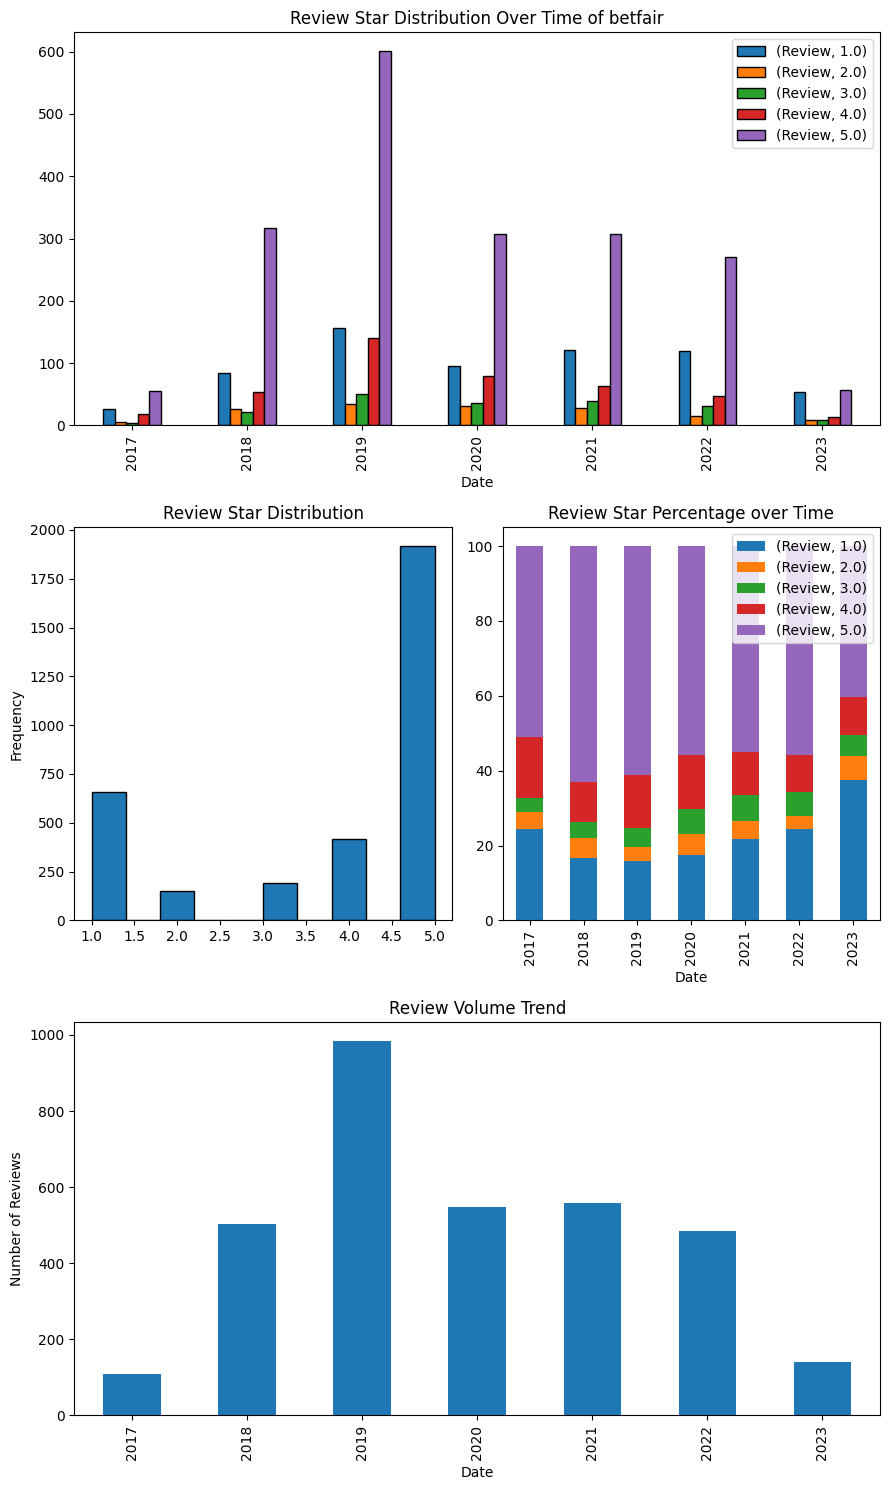

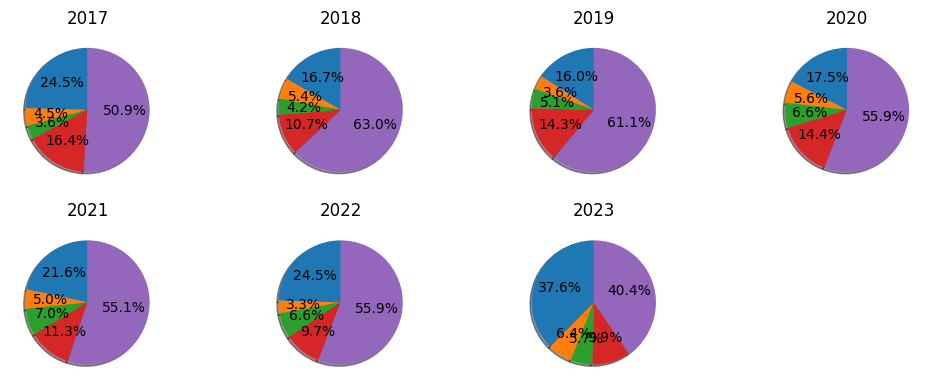

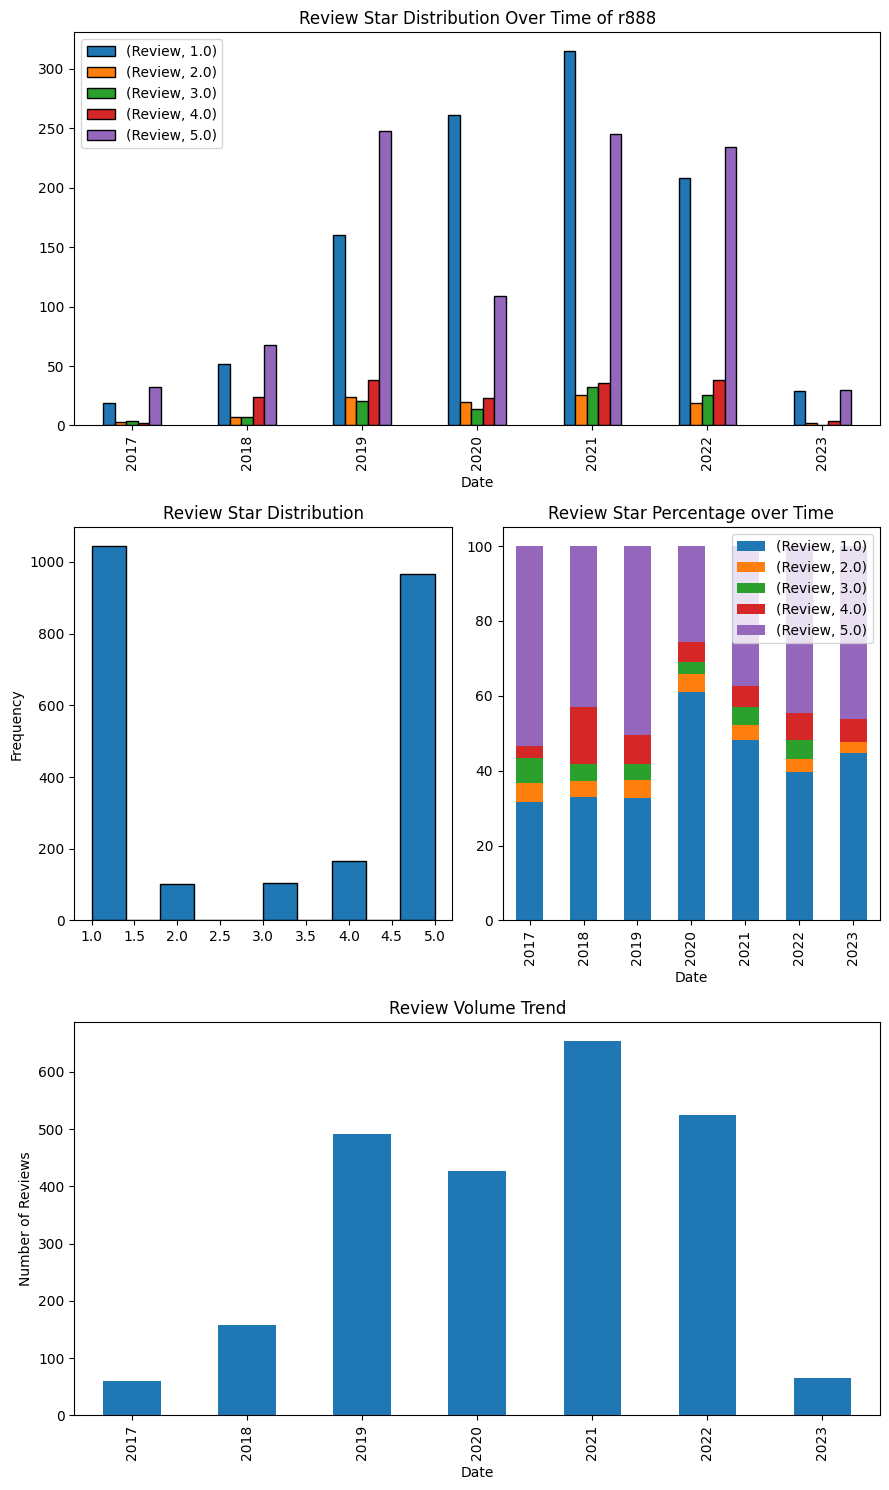

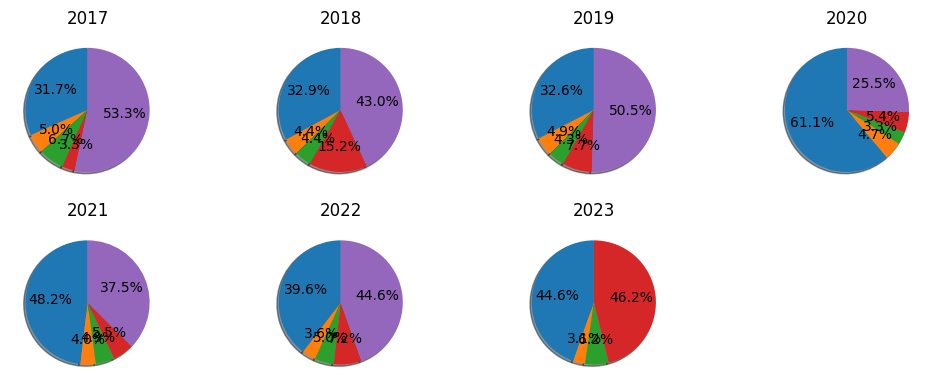

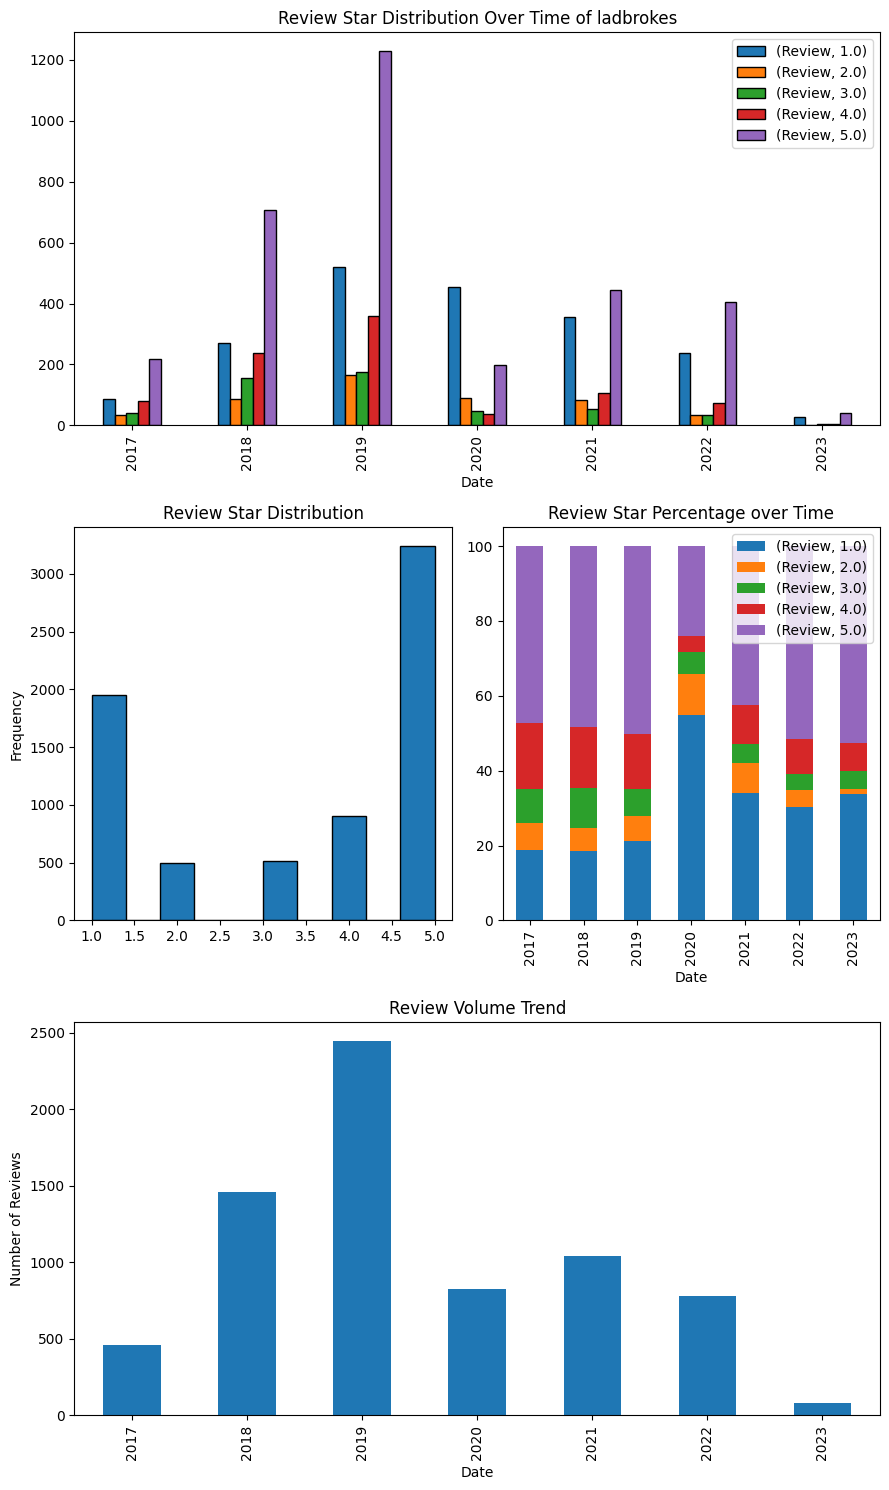

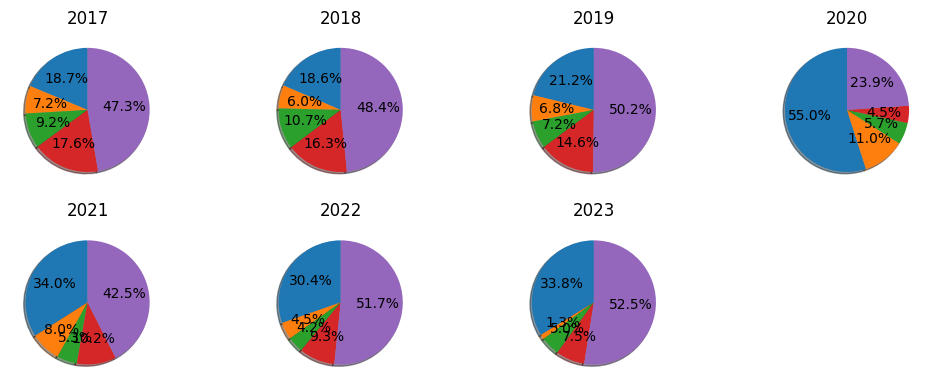

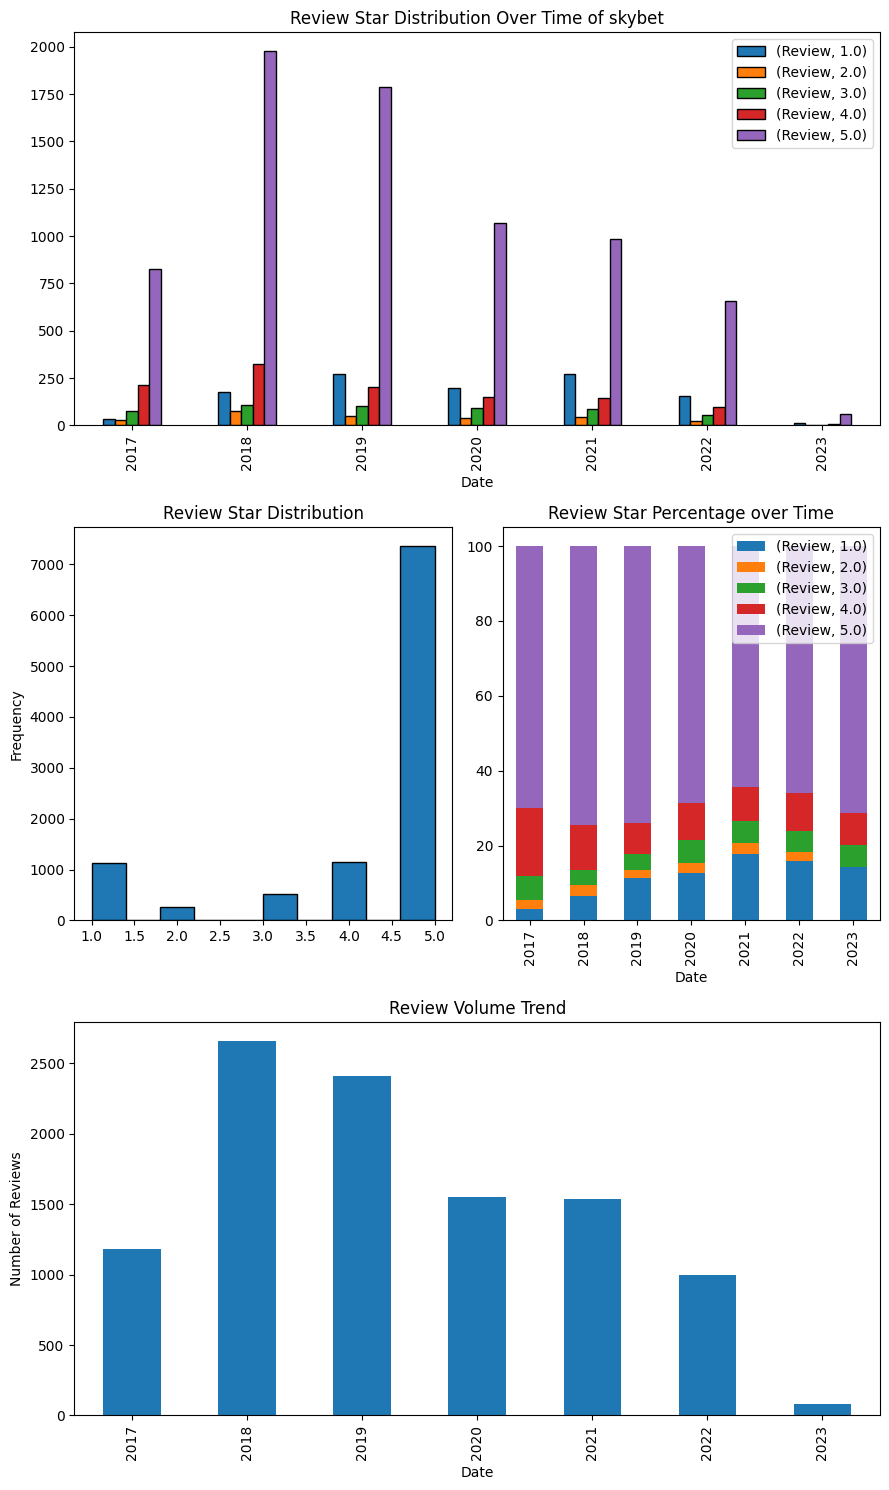

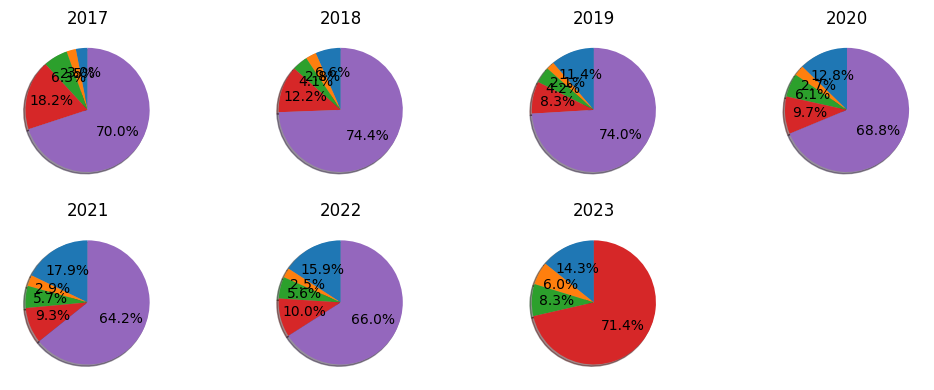

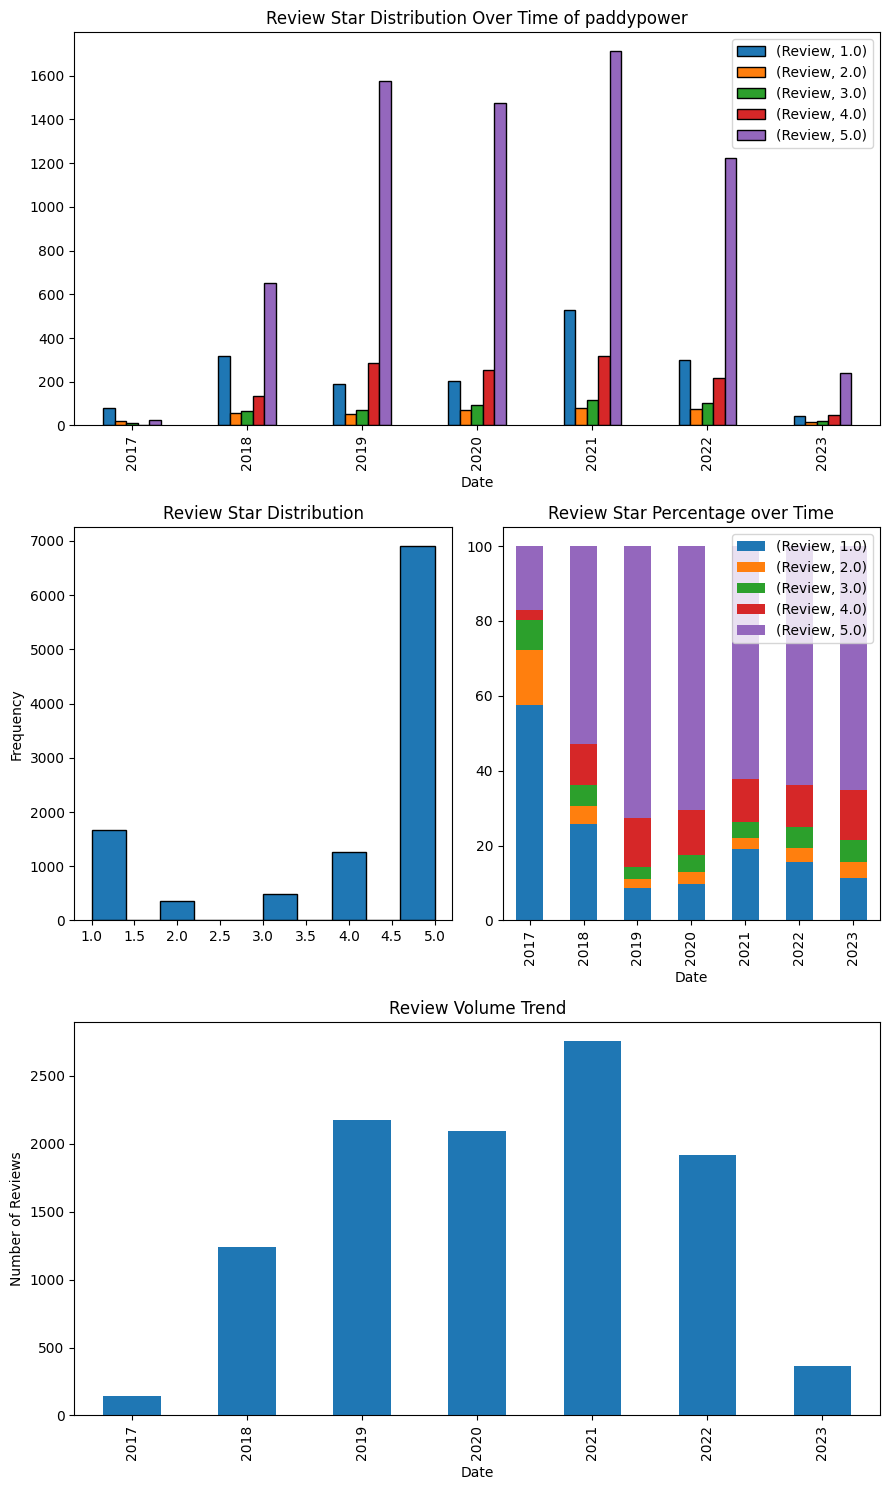

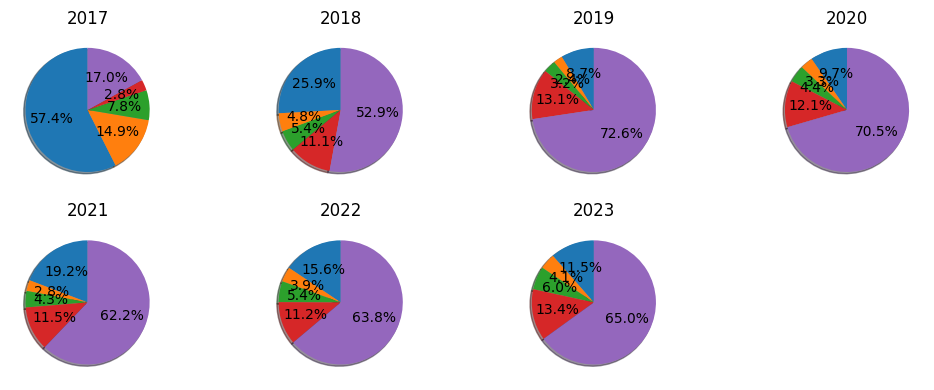

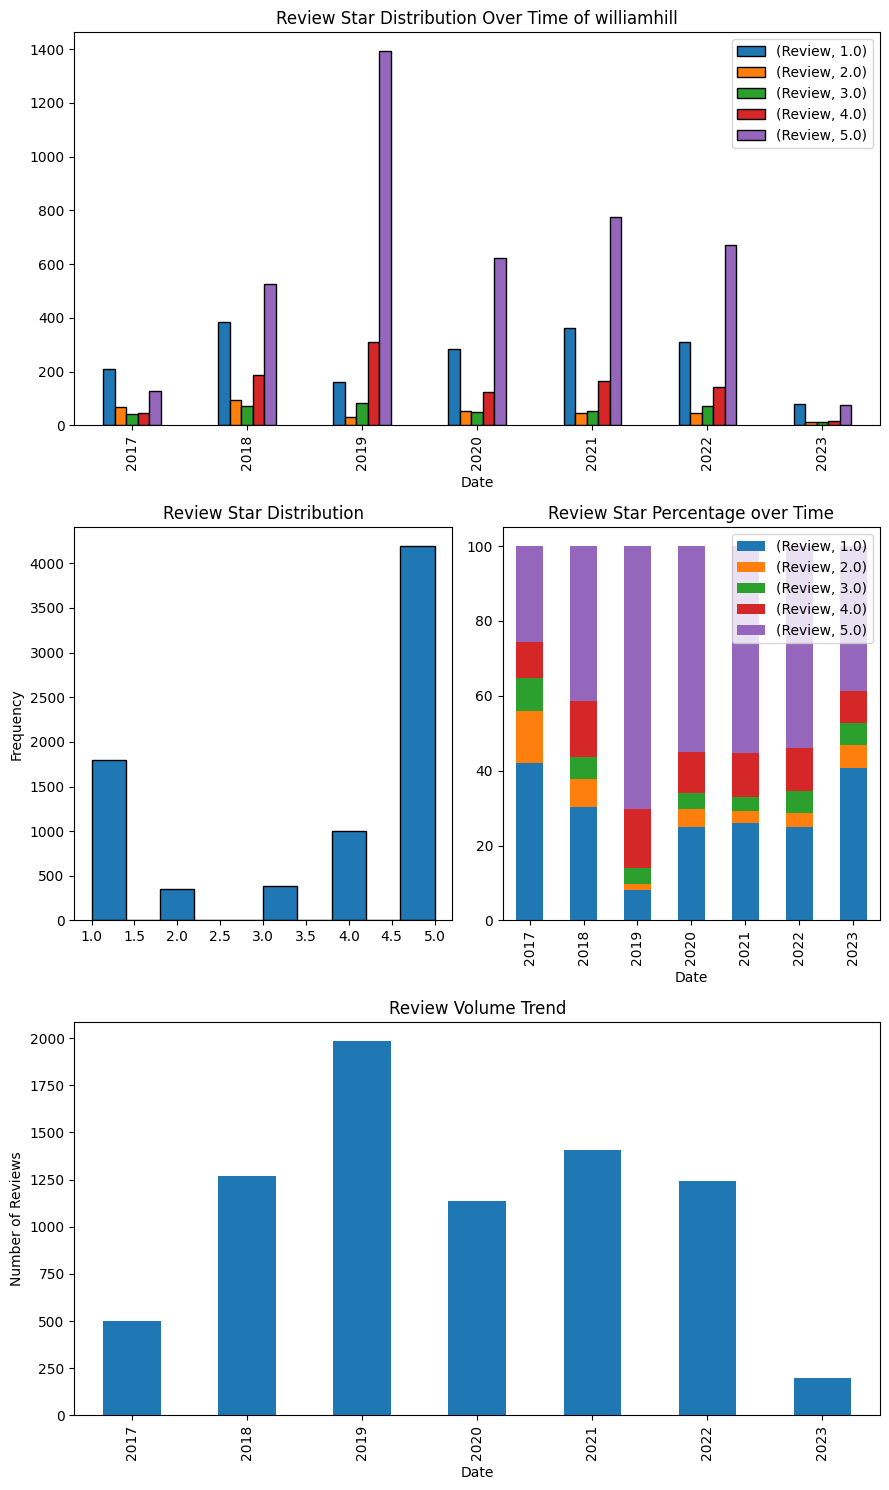

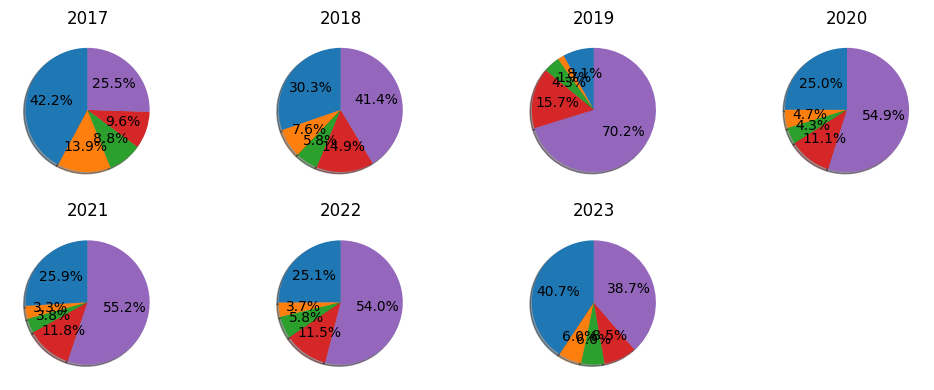

In [445]:
Company = ['betfair','r888','ladbrokes','skybet','paddypower','williamhill']
company_id = ['com.betfair.sportsbook','com.r888.rl','com.mobenga.ladbrokes','com.skybet.app.skybet','com.paddypower.sportsbook.u.inhouse','com.williamhill.sports.android']
language = ['en','en','en','en','en','en']
country = ['GB','GB','GB','GB','GB','GB']
Date = ['2011','2012','2013','2014','2015','2016','2017','2018','2019','2020','2021','2022','2023']

for i in range(len(Company)):
    try:
       os.makedirs('android_reviews/' + Company[i])
    except FileExistsError:
       # directory already exists
       pass
    filename = android_scrape(Company[i], company_id[i], language[i], country[i])
    android_plot(filename, Company[i], i)
    word_bag = android_reviews_word_freq(filename, Company[i], Date)
    concerned_key_word(word_bag, Company[i])
    pleased_key_word(word_bag, Company[i])

In [444]:
concerned_key_word(word_bag, 'r888')
pleased_key_word(word_bag, 'r888')

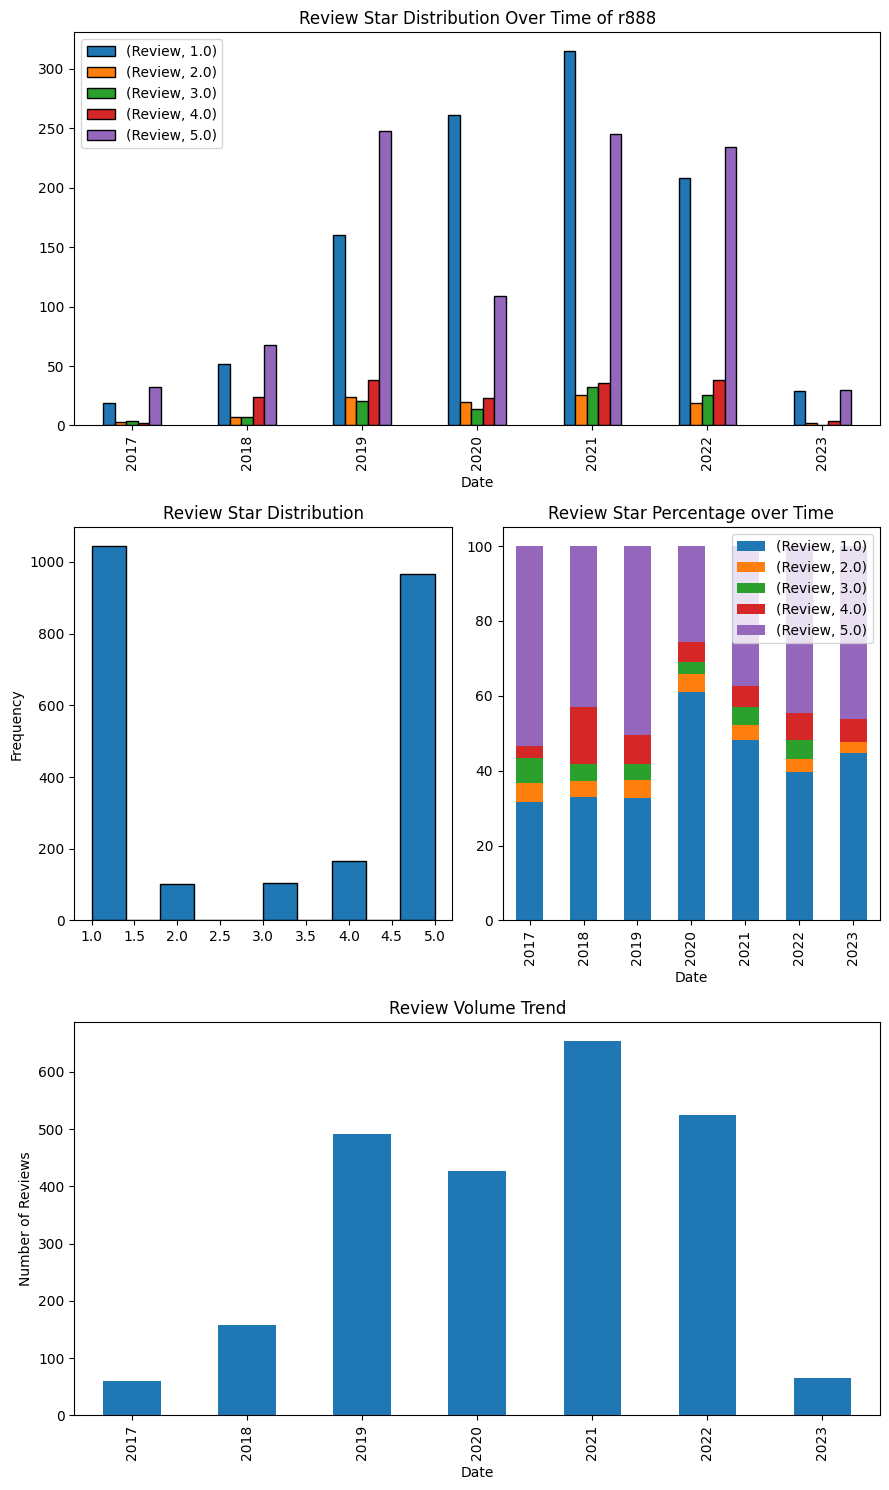

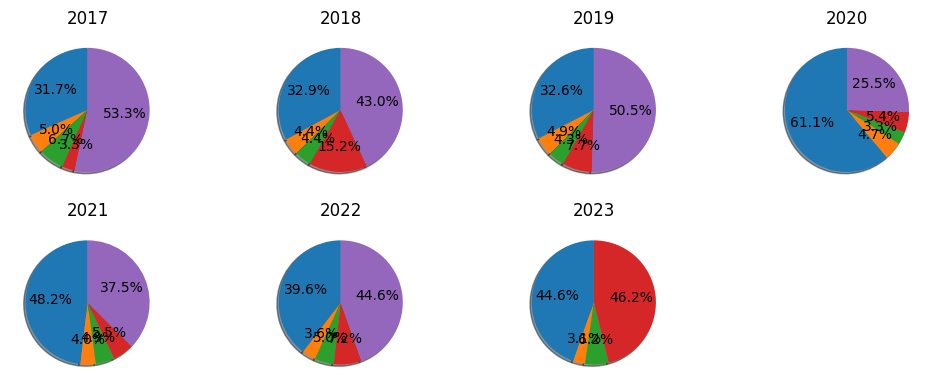

In [434]:
Company = 'r888'
company_id = 'com.r888.rl'
language = 'en'
country = 'GB'
Date = ['2011','2012','2013','2014','2015','2016','2017','2018','2019','2020','2021','2022','2023']


filename = android_scrape(Company, company_id, language, country)
android_plot(filename, Company, 0)
word_bag = android_reviews_word_freq(filename, Company, Date)
# concerned_key_word(word_bag, Company)

In [386]:
rw = reviews_all(
    'com.betfair.sportsbook',
    sleep_milliseconds=40, # defaults to 0
    lang='en', # defaults to 'en'
    country='GB', # defaults to 'us'
    sort=Sort.MOST_RELEVANT, # defaults to Sort.MOST_RELEVANT
#     filter_score_with=5 # defaults to None(means all score)
    )
df = pd.DataFrame(np.array(rw),columns=['review'])
df = df.join(pd.DataFrame(df.pop('review').tolist()))
df['Company'] = 'betfair'
df['Review'] = df['content']
df['Date'] = df['at']
df['Rate'] = df['score']
df = pd.DataFrame(df, columns = ['Date', 'Rate', 'Company', 'Review'])


In [442]:
# In Total for Each Brand

# Concerned
def concerned_key_word(word_bag, Company):
    Rate_concerned = [1,2,3]
    
    try:
       os.makedirs('android_reviews/'+Company+'/review_keywords')
    except FileExistsError:
       # directory already exists
       pass

    word_bag_pesudo_null = pd.DataFrame()
    for i in Rate_concerned:
        word_bag_pesudo = word_bag.loc[(word_bag['Rate'] == i)]

        word_bag_pesudo_null = pd.concat([word_bag_pesudo_null, word_bag_pesudo])

    dict_column_word = word_bag_pesudo_null['Word'].tolist()
    result_word = {}
    for d in dict_column_word:
        for key, value in d.items():
            if key in result_word:
                result_word[key] += value
            else:
                result_word[key] = value
    result_word = {k: v for k, v in sorted(result_word.items(), key=lambda item: item[1], reverse=True)}  

    dict_column_pair = word_bag_pesudo_null['Pair'].tolist()
    result_pair = {}
    for d in dict_column_pair:
        for key, value in d.items():
            if key in result_pair:
                result_pair[key] += value
            else:
                result_pair[key] = value

    result_pair = {k: v for k, v in sorted(result_pair.items(), key=lambda item: item[1], reverse=True)} 

    dict_column_tri = word_bag_pesudo_null['Tri'].tolist()
    result_tri = {}
    for d in dict_column_tri:
        for key, value in d.items():
            if key in result_tri:
                result_tri[key] += value
            else:
                result_tri[key] = value
    result_tri = {k: v for k, v in sorted(result_tri.items(), key=lambda item: item[1], reverse=True)} 


    word_bag_pesudo_new = pd.DataFrame({'Company': Company, 'Word': [result_word], 'Pair': [result_pair], 'Tri': [result_tri]})
    word_bag_pesudo_new.to_csv('android_reviews/'+Company+'/review_keywords/' + Company + '_overall_concerned_keywords' + '.csv')
    return     
 # Pleased
def pleased_key_word(word_bag, Company):
    Rate_pleased = [4,5]
    try:
       os.makedirs('android_reviews/'+Company+'/review_keywords')
    except FileExistsError:
       # directory already exists
       pass

    word_bag_pesudo_null = pd.DataFrame()
    for i in Rate_pleased:
        word_bag_pesudo = word_bag.loc[(word_bag['Rate'] == i)]

        word_bag_pesudo_null = pd.concat([word_bag_pesudo_null, word_bag_pesudo])

    dict_column_word = word_bag_pesudo_null['Word'].tolist()
    result_word = {}
    for d in dict_column_word:
        for key, value in d.items():
            if key in result_word:
                result_word[key] += value
            else:
                result_word[key] = value
    result_word = {k: v for k, v in sorted(result_word.items(), key=lambda item: item[1], reverse=True)}  

    dict_column_pair = word_bag_pesudo_null['Pair'].tolist()
    result_pair = {}
    for d in dict_column_pair:
        for key, value in d.items():
            if key in result_pair:
                result_pair[key] += value
            else:
                result_pair[key] = value

    result_pair = {k: v for k, v in sorted(result_pair.items(), key=lambda item: item[1], reverse=True)} 

    dict_column_tri = word_bag_pesudo_null['Tri'].tolist()
    result_tri = {}
    for d in dict_column_tri:
        for key, value in d.items():
            if key in result_tri:
                result_tri[key] += value
            else:
                result_tri[key] = value
    result_tri = {k: v for k, v in sorted(result_tri.items(), key=lambda item: item[1], reverse=True)} 


    word_bag_pesudo_new = pd.DataFrame({'Company': Company, 'Word': [result_word], 'Pair': [result_pair], 'Tri': [result_tri]})
    word_bag_pesudo_new.to_csv('android_reviews/'+Company+'/review_keywords/' + Company + '_overall_pleased_keywords' + '.csv')
    return       
        
        

In [424]:
reviews_content_sentiment

[["The performance of the current version of this app is shocking. It takes at least 30 seconds to complete any action. Every week, I put a small bet on my Super 6 accumulator. This week, I knew it would take 10 mins with this app to get it done, so didn't bother. For the first time in about 2 years, I would actually have won. I missed out on around £100 because this app is unusable. Tried clearing data, uninstalling / reinstalling, using data / wireless... Performance-wise, worst app I've used.",
  'negative',
  '1'],
 ["Fed up with it not working. It tells me to update to latest version and I have checked. When I deposit a blank screen comes up so I have to open exchange app to try that way. Now the home page doesn't load and when I click sports it only offers me virtual. Amazing the biggest betting company can't get an app right. Also the tab icons up top of screen I push and it opens something completely different. Usually roulette. Shall I continue?",
  'mixed',
  '1'],
 ["I love 